In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import geopandas as gpd
import numpy as np
from statistics import mean, stdev

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


# Helper functions

In [6]:
def create_network(year, threshold = 0):
    # Function for creating a directed weighted network of migration flows across municipalities
    df = pd.read_csv(f'./datasets/domestic_migration_{year}.csv')
    df['arrival_code'] = df['Area of arrival'].apply(lambda z: z[10:13])
    df['arrival'] = df['Area of arrival'].apply(lambda z: z[14:])
    df['departure_code'] = df['Area of departure'].apply(lambda z: z[12:15])
    df['departure'] = df['Area of departure'].apply(lambda z: z[16:])
    df['value'] = df['value'].astype('int')
    
    select = df[df['value'] > threshold].sort_values('value', ascending=False)
    temp = select[['departure_code', 'arrival_code', 'value']].values.tolist()
    weighted_edges = [(x[0], x[1], x[2]) for x in temp]
    weights = [x[2] for x in temp]
    
    # create graph
    G = nx.DiGraph()
    G.add_weighted_edges_from(weighted_edges)
    
    return G, weights, df

In [7]:
G, weights, df = create_network(2020)
# print(G.nodes)
# print(G.edges)
# print(G.edges(data=True))
# nx.draw_networkx(G)  # bad visualisation

In [8]:
# Create dictionaries mapping municipality codes to municipality names and vice versa
municipalities = list(df['arrival'])
municipality_codes = list(df['arrival_code'])
municipality_dict = {}
municipality_name_dict = {}
for m, mc in zip(municipalities, municipality_codes):
    if mc not in municipality_dict:
        municipality_dict[mc] = m
    if m not in municipality_name_dict:
        municipality_name_dict[m] = mc

In [20]:
df_key = pd.read_csv(f'./datasets/municipal_key_figures_1990_2021.csv', encoding = 'latin-1')

def create_key_figure_dictionary(key_figure):
    # Create dictionary of given key figure information on all years
    # Key figure values can be accessed from the returned dictionary by indexing dict[municipality_name][year]
    years = range(1990, 2022)

    df_key_figure = df_key[(df_key['Information'] == key_figure)]
    key_figure_list = df_key_figure[['Region 2021'] + [str(year) for year in years]].values.tolist()

    key_figure_dict = {}
    for elem in key_figure_list:
        municipality = elem[0]
        key_figures = elem[1:]
        key_figure_dict[municipality] = {}
        for i in range(len(years)):
            key_figure_dict[municipality][years[i]] = key_figures[i]

    # For some reason Maalahti is in Finnish in the English data even when all other Swedish-speaking municipalities are in Swedish
    # To fix this, let's add Maalahti (Malax in Swedish) to the dictionary manually
    key_figure_dict['Maalahti'] = {}
    for i in range(len(years)):
        key_figure_dict['Maalahti'][years[i]] = key_figure_dict['Malax'][years[i]]
        
    return key_figure_dict


# Create dictionary of municipality populations on each year
population = create_key_figure_dictionary('Population')

In [10]:
def visualize_migration_network(df = None, graph = None, threshold = 100):
    # Function from the demo, modified to accept graph input and a custom threshold (only effective when a data frame is given)
    # If a directed graph is given, plots the edges as arrows!
    
    if df is None and graph is None:
        print("Provide either a dataframe or a graph!")
        return
    
    gdf_kunta = gpd.read_file('./datasets/kunta4500k_2022.geojson')
    dict_centroid = dict(zip(gdf_kunta['kunta'], gdf_kunta.geometry.centroid.apply(lambda z: z.coords[0])))
    
    if df is not None:
        select = df[df['value'] > threshold].sort_values('value', ascending=False)
        temp = select[['departure_code', 'arrival_code']].values.tolist()
        edges = [(x[0], x[1]) for x in temp]
        temp = select[['value']].values.tolist()
        edge_sizes = [x[0] for x in temp]
    
        graph = nx.Graph()
        graph.add_edges_from(edges)
        
    elif graph is not None:
        edge_sizes = []
        for _,_,data in graph.edges(data=True):
            w = data['weight']
            edge_sizes.append(w)

    edge_sizes = [x / 1000 + 1 for x in edge_sizes]
    
    ax = gdf_kunta.plot(ec='black', fc='white', linewidth=0.5, figsize=(5, 10))

    nx.draw_networkx_edges(ax=ax,
                           G=graph,
                           pos=dict_centroid,
                           width=edge_sizes,
                           edge_color ='C1',
                           alpha=0.7)
    ax.set_axis_off()

In [11]:
gdf_kunta = gpd.read_file('./datasets/kunta4500k_2022.geojson')
dict_centroid = dict(zip(gdf_kunta['kunta'], gdf_kunta.geometry.centroid.apply(lambda z: z.coords[0])))

In [12]:
def calculate_domestic_net_migration(year):
    # Returns a dictionary where keys are municipality names and values are net migrations in the given year
    G, weights, _ = create_network(year)
    in_degrees = {node:in_degree for (node, in_degree) in G.in_degree(weight='weight')}
    out_degrees = {node:out_degree for (node, out_degree) in G.out_degree(weight='weight')}
    domestic_net_migration = {}
    for node in G.nodes():
        total = 0
        if node in in_degrees:
            total += in_degrees[node]
        if node in out_degrees:
            total -= out_degrees[node]
        domestic_net_migration[municipality_dict[node]] = total
        
    return domestic_net_migration


def calculate_real_net_migration(year):
    # Create dictionary of real population changes in the given year
    # Keys are municipality names and values real net population changes in the given year
    # NOTE: Does not work for 2021, as populations for 2022 are not available
    real_net_migration = {}
    for node in G.nodes():
        municipality = municipality_dict[node]
        real_net_migration[municipality] = population[municipality][year + 1] - population[municipality][year]
        
    return real_net_migration

# Basic visualisations

## Trends

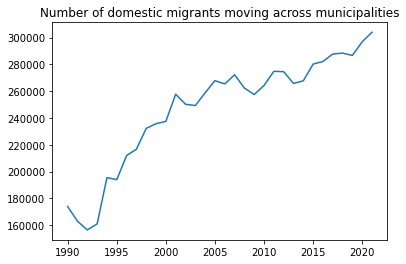

In [10]:
# Plot trend of total migration across municipalities
# The for loop takes a few seconds to run
sums = []
years = range(1990, 2022)
for year in years:
    _, weights, _ = create_network(year)
    sums.append(sum(weights))
    
plt.plot(years, sums)
plt.title("Number of domestic migrants moving across municipalities")
plt.show()

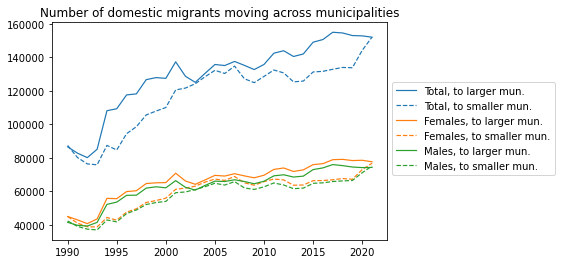

In [16]:
# Inspect the trend of moving to a smaller/larger municipality compared to municipality of departure

# Read complete migration data
df_complete = pd.read_csv('./datasets/domestic_migration_1990_2021_complete.csv')
df_complete['arrival'] = df_complete['Area of arrival'].apply(lambda z: z[14:])
df_complete['departure'] = df_complete['Area of departure'].apply(lambda z: z[16:])
df_complete['value'] = df_complete['value'].astype('int')

# Plot trend
sums_to_larger = []
sums_to_smaller = []
sums_to_larger_female = []
sums_to_smaller_female = []
sums_to_larger_male = []
sums_to_smaller_male = []
for year in years:
    sum_to_larger_female = 0
    sum_to_smaller_female = 0
    sum_to_larger_male = 0
    sum_to_smaller_male = 0
    df_year = df_complete[df_complete.Year == year]
    df_female = df_year[df_year.Sex == 'Females']
    df_male = df_year[df_year.Sex == 'Males']
    rows_female = df_female[['arrival', 'departure', 'value']].values.tolist()
    rows_male = df_male[['arrival', 'departure', 'value']].values.tolist()
    for arr, dep, val in rows_female:
        if population[arr][year] > population[dep][year]:
            sum_to_larger_female += val
        else:
            sum_to_smaller_female += val
    for arr, dep, val in rows_male:
        if population[arr][year] > population[dep][year]:
            sum_to_larger_male += val
        else:
            sum_to_smaller_male += val
            
    sums_to_larger_female.append(sum_to_larger_female)
    sums_to_smaller_female.append(sum_to_smaller_female)
    sums_to_larger_male.append(sum_to_larger_male)
    sums_to_smaller_male.append(sum_to_smaller_male)
    sums_to_larger.append(sum_to_larger_female + sum_to_larger_male)
    sums_to_smaller.append(sum_to_smaller_female + sum_to_smaller_male)

for data1, data2, colour in zip([sums_to_larger, sums_to_larger_female, sums_to_larger_male],
                               [sums_to_smaller, sums_to_smaller_female, sums_to_smaller_male],
                               ['C0', 'C1', 'C2']):
    plt.plot(years, data1, color = colour, linewidth = 1.2)
    plt.plot(years, data2, color = colour, linewidth = 1.2, linestyle = 'dashed')

plt.title("Number of domestic migrants moving across municipalities")
plt.legend(['Total, to larger mun.', 'Total, to smaller mun.', 'Females, to larger mun.', 'Females, to smaller mun.',
            'Males, to larger mun.', 'Males, to smaller mun.'],
          bbox_to_anchor=(1.0, 0.75))
plt.show()

## Net migration

### Histogram

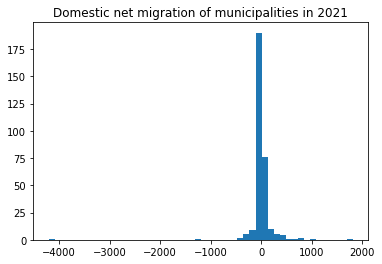

In [11]:
# Plot histogram of net migration
year = 2021
domestic_net_migration = calculate_domestic_net_migration(year)
domestic_net_migration_list = [v for k,v in domestic_net_migration.items()]
plt.hist(domestic_net_migration_list, bins=50)
plt.title(f"Domestic net migration of municipalities in {year}")
plt.show()

### Domestic net migration vs. real population change

In [9]:
# Compare domestic net migration and real population change

# Create scatter plot for each year excluding 2021 and save as a png
years_2020 = range(1990, 2021)
frames = []
for year in years_2020:
    domestic_net_migration = calculate_domestic_net_migration(year)
    real_net_migration = calculate_real_net_migration(year)

    # Create two lists where elements with the same index correspond to the same municipality
    x, y, labels, c = [], [], [], []
    for node in G.nodes():
        municipality = municipality_dict[node]
        # Only plot large cities
        if population[municipality][year] > 100000:
            x.append(domestic_net_migration[municipality])
            y.append(real_net_migration[municipality])
            labels.append(municipality)
            c.append(int(node))
    
    # Scatter plot
    plt.scatter(x, y, c=c, cmap='Set1')
    for i, label in enumerate(labels):
        plt.annotate(label, (x[i], y[i]), size=9)
    plt.axvline(color='k', lw=1)
    plt.axhline(color='k', lw=1)
    plt.axline((0,0), (1,1), color='k', lw=1)
    plt.title(f"Domestic vs. real net migration in {year}")
    plt.xlabel("domestic net migration")
    plt.ylabel("real net migration")
    plt.xlim([-4000, 7000])
    plt.ylim([-2000, 10000])
    # plt.show()
    plt.savefig(f'./img/img_{year}.png', transparent=False, facecolor='white')
    plt.close()
    
    image = imageio.imread(f'./img/img_{year}.png')
    frames.append(image)
print("Frames generated!")

# Create gif out of the created pngs
imageio.mimsave('./domestic_vs_real_net_migration.gif', frames, fps=1)
print("GIF generated!")

Frames generated!
GIF generated!


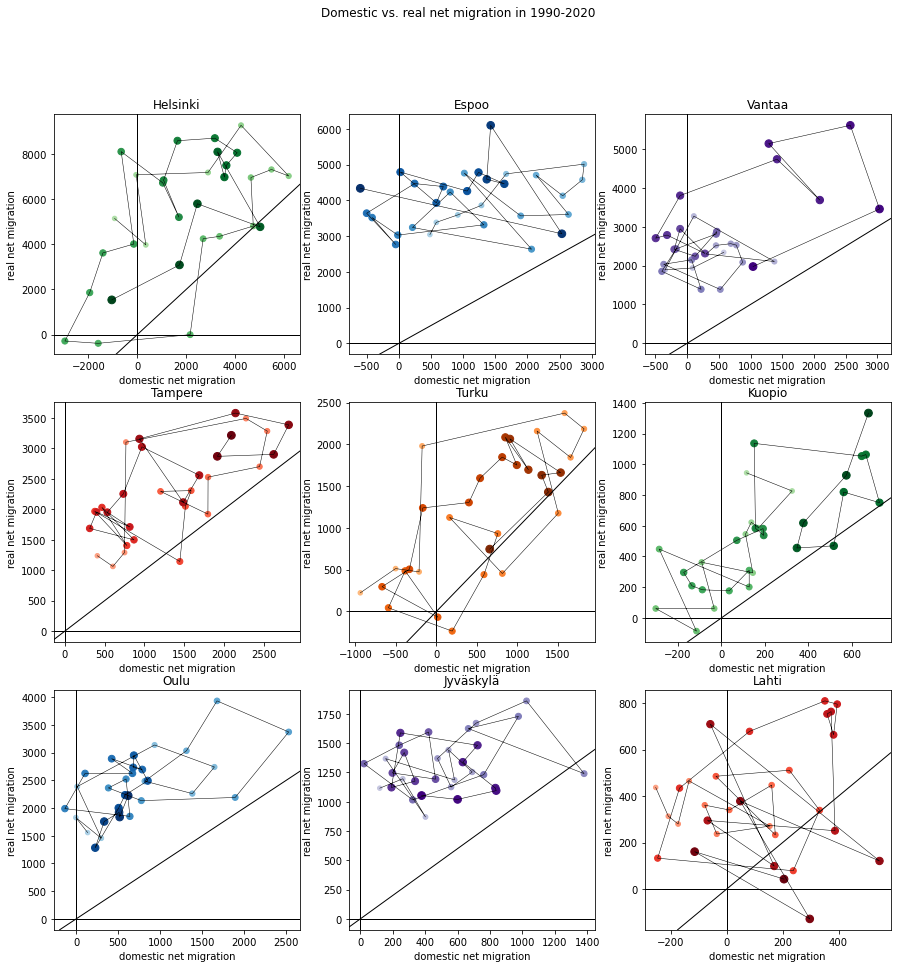

PNG saved!


In [66]:
# Domestic vs. real net migration trends of large municipalities as separate line plots

years_2020 = range(1990, 2021)

# Choice of (large) municipalities to plot the trends for
largest_municipalities = ['Helsinki', 'Espoo', 'Vantaa', 'Tampere', 'Turku', 'Kuopio', 'Oulu', 'Jyväskylä', 'Lahti']
cmaps = ['Greens', 'Blues', 'Purples', 'Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Reds']

smin, smax = 20, 60
s = [(smax-smin)/(years_2020[-1]-years_2020[0])*(x-years_2020[0])+smin for x in years_2020]

shared_xy = False
if shared_xy:
    fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15, 15))
else:
    fig, axs = plt.subplots(3,3, figsize=(15, 15))

fig.suptitle("Domestic vs. real net migration in 1990-2020")
for i, municipality in enumerate(largest_municipalities):
    ax = axs[i//3,i%3]
    x, y = [], []
    for year in years_2020:
        domestic_net_migration = calculate_domestic_net_migration(year)
        real_net_migration = calculate_real_net_migration(year)
        x.append(domestic_net_migration[municipality])
        y.append(real_net_migration[municipality])

    # Scatter plot
    ax.plot(x,y, c='k', lw=0.5)
    ax.scatter(x, y, c=years_2020, cmap=cmaps[i], s=s, vmin=1975)
    ax.axvline(c='k', lw=1)
    ax.axhline(c='k', lw=1)
    ax.axline((0,0), (1,1), c='k', lw=1)
    ax.set_title(f"{municipality}")
    ax.set_xlabel("domestic net migration")
    ax.set_ylabel("real net migration")
    if shared_xy:
        ax.set_xlim([-4000, 7000])
        ax.set_ylim([-2000, 10000])
    
plt.savefig('./Domestic_vs_real_net_migration.png')
plt.show()
print("PNG saved!")

### Trend of net migration on the map

In [23]:
# Visualise trend of net migrations on the map of Finland

same_scale = False
if same_scale:
    vmin = -6194
    vmax = 6194
    
frames = []
for year in range(1990, 2022):
    domestic_net_migration = calculate_domestic_net_migration(year)
    domestic_net_migration_list = []
    municipalities = gdf_kunta['name']
    for municipality in municipalities:
        if municipality != 'Malax':
            domestic_net_migration_list.append(domestic_net_migration[municipality])
        else:
            domestic_net_migration_list.append(domestic_net_migration['Maalahti'])

    if not same_scale:
        vmin, vmax = min(domestic_net_migration_list), max(domestic_net_migration_list)
        if abs(vmin) > vmax:
            vmax = abs(vmin)
        elif vmax > abs(vmin):
            vmin = -vmax
    domestic_net_migration_list = np.array(domestic_net_migration_list)
    gdf_kunta.plot(column=domestic_net_migration_list, ec='black', figsize=(5,10), linewidth=0.3,
                   cmap="RdBu", vmin=vmin, vmax=vmax)
    plt.title(f"Domestic net migration in {year}")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./img/img_{year}.png', transparent=False, facecolor='white')
    plt.close()
    
    image = imageio.imread(f'./img/img_{year}.png')
    frames.append(image)
print("Frames generated!")
    
# Create gif out of the created pngs
imageio.mimsave('./domestic_net_migration_trend.gif', frames, fps=1)
print("GIF generated!")

Frames generated!
GIF generated!


## Maximum Spanning Tree

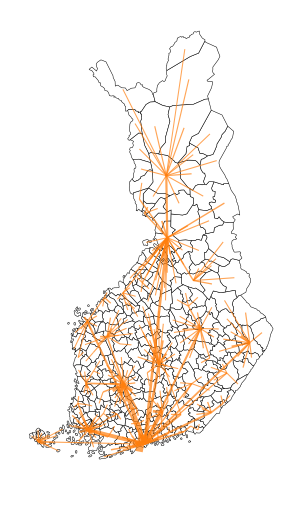

In [20]:
# Visualise Maximum Spanning Tree (MST)

# First, create an undirected network where the edge weights are the sums of migrants in both directions (for now)
def create_undirected_network(G):
    G_undir = nx.Graph()
    for u,v,data in G.edges(data=True):
        w = data['weight']
        if G_undir.has_edge(u,v):
            G_undir[u][v]['weight'] += w
        else:
            G_undir.add_edge(u, v, weight=w)
    return G_undir


year = 2020
G, _, _ = create_network(year, threshold = 0)


def normalise_weights(G):
    # Divide weights by population of departure municipality
    for u,v,data in G.edges(data=True):
        w = data['weight']
        G[u][v]['weight'] = w / population[municipality_dict[u]][year]


# normalise_weights(G)
G_undir = create_undirected_network(G)

# The MST
mst = nx.maximum_spanning_tree(G_undir)
visualize_migration_network(graph = mst)

## Migration distance

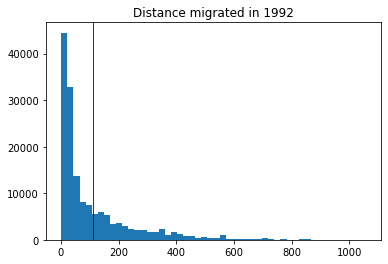

Mean: 109.64 KM, SD: 139.58 KM


In [34]:
# Examine how far people migrate domestically, visualise the distribution with a histogram

# Code provided by the TA
def get_distance(coords1, coords2):
    return np.sqrt((coords1[0] - coords2[0])**2 + (coords1[1] - coords2[1])**2) / 1000

distances = []
year = 1992
G, _, _ = create_network(year)
for u,v,data in G.edges(data=True):
    w = data['weight']
    dist = get_distance(dict_centroid[u], dict_centroid[v])
    distances = distances + [float(dist) for i in range(w)]
    
# Calculate basic statistics
dist_mean = mean(distances)
dist_sd = stdev(distances)

# Plot histogram
plt.hist(distances, bins=50)
plt.axvline(x=dist_mean, color='k', lw=0.8)
plt.title(f"Distance migrated in {year}")
plt.show()

print(f"Mean: {dist_mean:.2f} KM, SD: {dist_sd:.2f} KM")

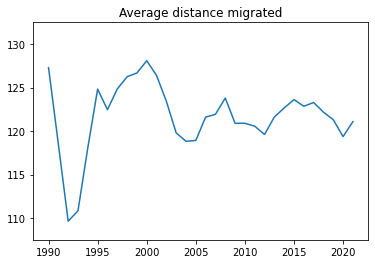

In [39]:
# Plot trend of average distance migrated

dist_means = []
for year in years:
    sum_dist = 0
    num_dist = 0
    G, _, _ = create_network(year)
    for u,v,data in G.edges(data=True):
        w = data['weight']
        dist = get_distance(dict_centroid[u], dict_centroid[v])
        sum_dist += w*dist
        num_dist += w
    dist_means.append(sum_dist/num_dist)
    
plt.plot(years, dist_means)
plt.title("Average distance migrated")
plt.ylim([107.5, 132.5])
plt.show()

## Swedish-speaking population

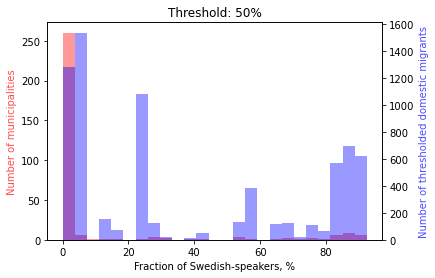

PNG saved!


In [123]:
# How does the amount of Swedish-speakers in the departure municipality affect the same metric of the arrival municipality?
# I.e. do Swedish-speakers prefer to move to other municipalities where a lot of people speak Swedish?

year = 2021

# Create dictionary of fractions of Swedish-speakers in the municipalities each year
swedish_speakers = create_key_figure_dictionary('Share of Swedish-speakers of the population, %')

# First, create a list of the Swedish-speaking fraction of municipalities for reference
swedish = []
G, _, _ = create_network(year)
for node in G.nodes():
    mun = municipality_dict[node]
    swedish.append(swedish_speakers[mun][year])

# Then, create a weighted list of Swedish-speaking fractions of arrival municipalities when the departure municipality
# has a Swedish-speaker fraction over the threshold defined below
threshold = 50
x = []
for u,v,data in G.edges(data=True):
    w = data['weight']
    mun1, mun2 = municipality_dict[u], municipality_dict[v]
    if swedish_speakers[mun1][year] > threshold:
        x += w * [swedish_speakers[mun2][year]]

        
# Plot both data in the same histogram
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(swedish, bins=25, color='r', alpha=0.4)
ax2.hist(x, bins=25, color='b', alpha=0.4)
ax1.set_xlabel('Fraction of Swedish-speakers, %')
ax1.set_ylabel('Number of municipalities', color='r', alpha=0.7)
ax2.set_ylabel('Number of thresholded domestic migrants', color='b', alpha=0.7)
plt.title(f'Threshold: {threshold}%')

plt.savefig(f'./swedish_speakers_migration_{threshold}.png')
plt.show()
print("PNG saved!")